## Driver code for training models to learn pipeline 1 x pipeline 2 transform maps
- Note: currently using output after atlas-based grouping
- Atlas used: aparc (Freesurfer) DKT-31 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../lib')
from data_handling import *
from data_stats import *
from deeplearning import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
#proj_dir = '/Users/nikhil/projects/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
results_dir = data_dir + 'results/'

demograph_file = 'ABIDE_Phenotype.csv'
dkt_roi_names = 'DKT_parcel_map_FS_CIVET.csv'

ants_file = 'ABIDE_ants_thickness_data.csv' #uses modified (mindboggle) dkt atlas with 31 ROIs
civet_file = 'ABIDE_civet2.1_thickness_test1.csv'

fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs60_lh_file = 'lh.aparc.thickness.table.test1' #'aparc_lh_thickness_table.txt' #'lh.aparc.thickness.table.test1'
fs60_rh_file = 'rh.aparc.thickness.table.test1' #'aparc_rh_thickness_table.txt' #'rh.aparc.thickness.table.test1'


### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# ROI names
dkt_roi_map = pd.read_csv(data_dir + dkt_roi_names)

# CIVET 2.1
civet_data = pd.read_csv(data_dir + civet_file, dtype={subject_ID_col: str})
print('shape of civet data {}'.format(civet_data.shape))
civet_data_std = standardize_civet_data(civet_data, subject_ID_col, dkt_roi_map)
print('shape of stdized civet data {}'.format(civet_data_std.shape))
print('')

# ANTs
ants_data = pd.read_csv(data_dir + ants_file, header=2)
print('shape of ants data {}'.format(ants_data.shape))
ants_data_std = standardize_ants_data(ants_data, subject_ID_col)
print('shape of stdized ants data {}'.format(ants_data_std.shape))
print('')

# FS
fs53_data = pd.read_csv(data_dir + fs53_file)
print('shape of fs53 data {}'.format(fs53_data.shape))
fs53_data_std = standardize_fs_data(fs53_data, subject_ID_col)
print('shape of stdized fs53 data {}'.format(fs53_data_std.shape))
print('')

fs51_data = pd.read_csv(data_dir + fs51_file)
print('shape of fs51 data {}'.format(fs51_data.shape))
fs51_data_std = standardize_fs_data(fs51_data, subject_ID_col)
print('shape of stdized fs51 data {}'.format(fs51_data_std.shape))
print('')

fs60_lh_data = pd.read_csv(fs60_dir + fs60_lh_file, delim_whitespace=True)
fs60_rh_data = pd.read_csv(fs60_dir + fs60_rh_file, delim_whitespace=True)
print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))

fs60_data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col)
print('shape of stdized fs60 data {}'.format(fs60_data_std.shape))

shape of civet data (899, 65)
shape of stdized civet data (899, 65)

shape of ants data (1101, 99)
shape of stdized ants data (1101, 90)

shape of fs53 data (976, 74)
shape of stdized fs53 data (976, 74)

shape of fs51 data (1112, 74)
shape of stdized fs51 data (1112, 74)

shape of fs60 data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 data (1047, 71)


### Create master dataframe

In [5]:
data_dict = {'civet': civet_data_std,
            'fs60' : fs51_data_std}

na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 
master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls, after shift 0:ASD, 1:Controls)
# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP']-1
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}({}), ROIs {}'.format(len(common_subs), master_df_raw[master_df_raw['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_roi_cols)))


Number of datasets: 2
Finding common subject and columns
dataset : fs60
common subs: 1112
dataset : civet
common subs: 899
Number of common subjects and columns: 899, 63

checking fs60 dataframe
Shape of the dataframe based on common cols and subs (899, 63)
Basic data check passed
Shape of the concat dataframe (899, 64)

checking civet dataframe
Shape of the dataframe based on common cols and subs (899, 63)
Basic data check passed
Shape of the concat dataframe (1798, 64)

master df shape after adding demographic info (1798, 68)

Number of common subjects 899({0: 432, 1: 467}), ROIs 62


### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 

In [6]:
qc_type = 'None' #condition: master_df['QC_maarten']==0, master_df['QC_gleb'].isin['1','-+1']

if qc_type in ['maarten','gleb']:
    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
    master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
    master_df = master_df[master_df['QC_maarten']==0]
    print('Filtering based on {} QC. Resultant number of subjects {} ({}) (out of {})'.format(qc_type,len(master_df[subject_ID_col].unique()),master_df[master_df['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_subs)))
    common_subs = master_df[subject_ID_col].unique()
else:
    master_df = master_df_raw
    print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))
    


No QC performed. master_df shape 899


### Compare ML performance 

In [7]:
n_splits = 1
test_size = 0.2

input_pipe = 'fs60'
output_pipe = 'civet'

ml_demograph = master_df[master_df['pipeline']=='fs60'][[subject_ID_col,'DX_GROUP','SEX']]
X = master_df[master_df['pipeline']==input_pipe][[subject_ID_col] + common_roi_cols]
Y = master_df[master_df['pipeline']==output_pipe][[subject_ID_col] + common_roi_cols]

subject_idx = ml_demograph[subject_ID_col]
dx = ml_demograph['DX_GROUP']

print('Shape X {}, Y {}'.format(X.shape, Y.shape))
print('Shape subject_ids {}, dx {}'.format(subject_idx.shape, dx.shape))

# Use subject_ids for indexing to maintain correspondance between X and Y
# Use dx for stratification
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
cv_list = []
for train_index, test_index in sss.split(subject_idx, dx):
    subject_idx_train = subject_idx[train_index]
    subject_idx_test = subject_idx[test_index]
    X_train, X_test = X[X[subject_ID_col].isin(subject_idx_train)], X[X[subject_ID_col].isin(subject_idx_test)]
    Y_train, Y_test = Y[Y[subject_ID_col].isin(subject_idx_train)], Y[Y[subject_ID_col].isin(subject_idx_test)]
    cv_list.append((X_train,X_test,Y_train,Y_test))
    print('')
    print('Train Shapes X {}, Y {}'.format(X_train.shape, Y_train.shape))
    print('Test Shapes X {}, Y {}'.format(X_test.shape, Y_test.shape))

print('\n number of CV folds {}'.format(len(cv_list)))

Shape X (899, 63), Y (899, 63)
Shape subject_ids (899,), dx (899,)

Train Shapes X (719, 63), Y (719, 63)
Test Shapes X (180, 63), Y (180, 63)

 number of CV folds 1


In [8]:
# training params
lr = 0.01
n_epochs = 50
validate_after = 10
batch_size = 20
dropout = 11 #keep_prob
verbose = False # Do you want to print perf after every epoch?? 
save_model = False
save_model_path = './'

net_arch = {'input':62,'n_layers':5,'l1':10,'l2':10,'l3':10,'l4':10,'l5':10,'output':62,
            'reg':0.01, 'loss_type':'mse'}

test_err_melt_concat = pd.DataFrame()

for fold in range(len(cv_list)):
    print('\nStarting fold {}'.format(fold))
    X_train,X_test,Y_train,Y_test = cv_list[fold]
    
    tf.reset_default_graph()
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:        
        # Train model    
        data = {'X':X_train[common_roi_cols].values,'y':Y_train[common_roi_cols].values}    

        simple_ae = pipeline_AE(net_arch)                
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(simple_ae.loss)
        tf.global_variables_initializer().run()
        saver = tf.train.Saver()

        cur_time = datetime.time(datetime.now())
        print('\nStart training time: {}'.format(cur_time))                
        simple_ae, train_metrics = train_network(sess, simple_ae, data, optimizer, n_epochs, batch_size, dropout,validate_after,verbose)

        #Save trained model
        if save_model:
            print('saving model at {}'.format(save_model_path + 'simple_ae_example'))
            saver.save(sess, save_model_path + 'simple_ae_example')

        cur_time = datetime.time(datetime.now())
        print('End training time: {}\n'.format(cur_time))  

        # Test model      
        data = {'X':X_test[common_roi_cols].values,'y':Y_test[common_roi_cols].values}

        _,test_metrics = test_network(sess,simple_ae,data)        
        
        # Null Test: create fake output from output itself
        # (Should be worse than actual performance)
        data = {'X':Y_test[common_roi_cols].values,'y':Y_test[common_roi_cols].values}

        _,test_metrics_null = test_network(sess,simple_ae,data)        
        
        # populate perf dataframe
        test_err = pd.DataFrame()
        test_err[subject_ID_col] = Y_test[subject_ID_col]
        test_err[common_roi_cols] = Y_test[common_roi_cols] - test_metrics['test_preds']
        test_err_melt = pd.melt(test_err, id_vars =[subject_ID_col], value_vars =common_roi_cols, 
                               var_name ='ROI', value_name ='err')
        test_err_melt['fold'] = np.tile(fold,len(test_err_melt))
        test_err_melt['model'] = np.tile('real',len(test_err_melt))
        test_err_melt_concat = test_err_melt_concat.append(test_err_melt)
        
        # Null test
        test_err_null = pd.DataFrame()
        test_err_null[subject_ID_col] = Y_test[subject_ID_col]
        test_err_null[common_roi_cols] = Y_test[common_roi_cols] - test_metrics_null['test_preds']
        test_err_null_melt = pd.melt(test_err_null, id_vars =[subject_ID_col], value_vars =common_roi_cols, 
                               var_name ='ROI', value_name ='err')
        test_err_null_melt['fold'] = np.tile(fold,len(test_err_null_melt))
        test_err_null_melt['model'] = np.tile('null',len(test_err_null_melt))
        
        # Append to the same dataframe since subject IDs are the same 
        test_err_melt_concat = test_err_melt_concat.append(test_err_null_melt)
        print('\nEnding fold {}'.format(fold))



Starting fold 0

Start training time: 17:10:26.745974
performance on entire train and valid subsets
epoch 0	 train_loss:9.59	 valid_loss:9.49

performance on entire train and valid subsets
epoch 10	 train_loss:0.63	 valid_loss:0.60

performance on entire train and valid subsets
epoch 20	 train_loss:0.11	 valid_loss:0.09

performance on entire train and valid subsets
epoch 30	 train_loss:0.06	 valid_loss:0.08

performance on entire train and valid subsets
epoch 40	 train_loss:0.10	 valid_loss:0.21

End training time: 17:10:27.833045

Testing model
Loss test set 0.05
Testing model
Loss test set 0.07

Ending fold 0


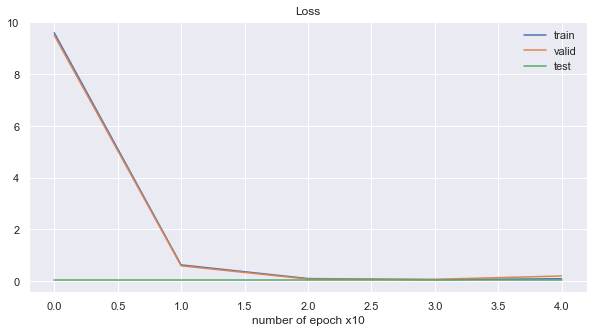

In [9]:
train_loss = train_metrics['train_loss']
valid_loss = train_metrics['valid_loss']
test_loss = test_metrics['test_loss']

plt.figure(figsize=(10,5))
plt.style.use('seaborn-white')
sns.set(font_scale=1)
plt.plot(train_loss,label='train');
plt.plot(valid_loss,label='valid');
plt.plot(np.tile(test_loss,len(train_loss)),label='test');
plt.title('Loss')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()


### Errors and Correlations between pipelines

In [10]:
# Before and after prediction 
df1 = X_test
df2 = Y_test
df3 = pd.DataFrame(columns=common_roi_cols,data=test_metrics['test_preds'])
df3[subject_ID_col] = df1[subject_ID_col].values
df4 = pd.DataFrame(columns=common_roi_cols,data=test_metrics_null['test_preds'])
df4[subject_ID_col] = df1[subject_ID_col].values

pipeline_err = pd.DataFrame(columns=[subject_ID_col]+common_roi_cols)
model_err_null = pd.DataFrame(columns=[subject_ID_col]+common_roi_cols)
model_err = pd.DataFrame(columns=[subject_ID_col]+common_roi_cols)

pipeline_err[subject_ID_col] = df1[subject_ID_col].values
pipeline_err[common_roi_cols] = (df1[common_roi_cols].values - df2[common_roi_cols].values)**2
model_err[subject_ID_col] = df1[subject_ID_col].values
model_err[common_roi_cols] = (df3[common_roi_cols].values - df2[common_roi_cols].values)**2
model_err_null[subject_ID_col] = df1[subject_ID_col].values
model_err_null[common_roi_cols] = (df4[common_roi_cols].values - df2[common_roi_cols].values)**2

#MSE
print('pipeline 1 vs pipeline 2 MSE: {:4.2f}'.format(pipeline_err[common_roi_cols].values.mean()))
print('null model predictions vs pipeline 2 MSE: {:4.2f}'.format(model_err_null[common_roi_cols].values.mean()))
print('model predictions vs pipeline 2 MSE: {:4.2f}'.format(model_err[common_roi_cols].values.mean()))

#Corr
pipeline_xcorr_df = cross_correlations(df1,df2,subject_ID_col)
print('pipeline 1 vs pipeline 2 correlation: {:4.2f}'.format(pipeline_xcorr_df['correlation'].mean()))
model_null_xcorr_df = cross_correlations(df4,df2,subject_ID_col)
print('null model predictions vs pipeline 2 correlation: {:4.2f}'.format(model_null_xcorr_df['correlation'].mean()))
model_xcorr_df = cross_correlations(df3,df2,subject_ID_col)
print('model predictions vs pipeline 2 correlation: {:4.2f}'.format(model_xcorr_df['correlation'].mean()))

pipeline 1 vs pipeline 2 MSE: 0.46
null model predictions vs pipeline 2 MSE: 0.07
model predictions vs pipeline 2 MSE: 0.05
pipeline 1 vs pipeline 2 correlation: 0.52
null model predictions vs pipeline 2 correlation: 0.04
model predictions vs pipeline 2 correlation: 0.03


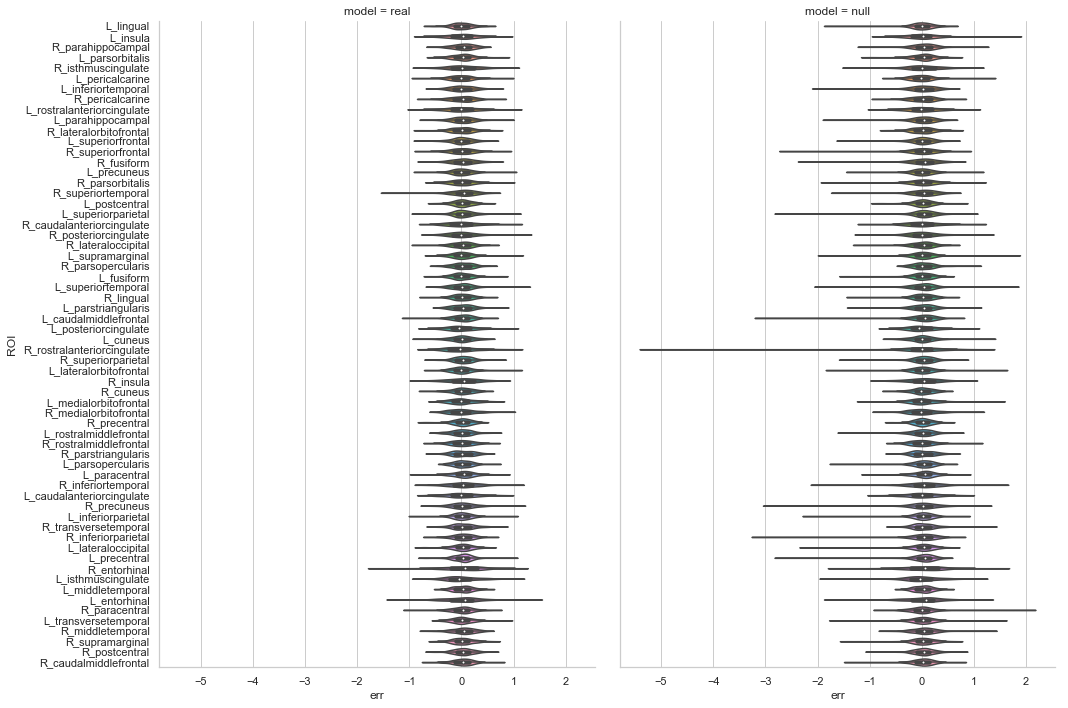

In [11]:
plot_df = test_err_melt_concat
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='err',y='ROI',order=common_roi_cols,col='model',
                data=plot_df,aspect=0.75,height=10,kind='violin')